# Desarrollo de MVP para datos de Sernageomin con satelite Sentinel-2

## Análisis Inicial

1. Preparar el entorno
- Instalar las líbrerias necesarias en el entorno del notebook

In [1]:
%pip install sentinelhub numpy matplotlib geopandas rasterio shapely


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sentinelhub import (
    SentinelHubRequest, DataCollection, MimeType, CRS, BBox, bbox_to_dimensions
)
from shapely.geometry import Point
import rasterio
from rasterio.plot import show


In [3]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

In [5]:
# Cargar el archivo Excel
file_path = r"C:\Users\rodag\OneDrive\Documentos\Magister\Tesina\MVP\Datos\catastro.xlsx"
catastro_df = pd.read_excel(file_path)

# Mostrar las primeras filas del DataFrame
print(catastro_df.head())

   OBJECTID Código de la remoción en masa         Región  \
0         1                RM-1965-01-001     Valparaíso   
1         2                RM-1965-01-002     Valparaíso   
2         3                RM-1967-01-001    Antofagasta   
3         4                RM-1979-01-001      Araucanía   
4         5                RM-1985-01-001  Metropolitana   

  Tipo de remoción en masa Tipo de material  \
0            Deslizamiento  Suelo/Sedimento   
1                    Caída  Suelo/Sedimento   
2            Deslizamiento  Sin información   
3            Deslizamiento  Suelo/Sedimento   
4                    Flujo  Suelo/Sedimento   

    Clasificación de remoción en masa       Detonante Día del evento  \
0         Deslizamiento indeterminado  Evento Sísmico             28   
1  Caída de bloque/detrito/arena/limo  Evento Sísmico             28   
2         Deslizamiento indeterminado  Evento Sísmico             28   
3         Deslizamiento indeterminado         Lluvias               

In [6]:
catastro_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   OBJECTID                               2880 non-null   int64  
 1   Código de la remoción en masa          2880 non-null   object 
 2   Región                                 2880 non-null   object 
 3   Tipo de remoción en masa               2880 non-null   object 
 4   Tipo de material                       2880 non-null   object 
 5   Clasificación de remoción en masa      2880 non-null   object 
 6   Detonante                              2880 non-null   object 
 7   Día del evento                         2880 non-null   object 
 8   Mes de inicio del evento               2880 non-null   object 
 9   Año del evento                         2880 non-null   int64  
 10  Estación de ocurrencia del evento      2880 non-null   object 
 11  Méto

In [7]:
print(catastro_df.describe())

          OBJECTID  Año del evento      Latitud     Longitud
count  2880.000000     2880.000000  2880.000000  2880.000000
mean   1440.500000     1246.012847   -35.190177   -71.000761
std     831.528713      976.909497     9.147794     0.981890
min       1.000000        0.000000   -54.857698   -80.798268
25%     720.750000        0.000000   -37.899143   -71.082328
50%    1440.500000     2010.000000   -33.787396   -70.843777
75%    2160.250000     2017.000000   -29.829353   -70.342140
max    2880.000000     2021.000000   -17.724732   -68.507165


In [8]:
print(catastro_df.isnull().sum())

OBJECTID                                 0
Código de la remoción en masa            0
Región                                   0
Tipo de remoción en masa                 0
Tipo de material                         0
Clasificación de remoción en masa        0
Detonante                                0
Día del evento                           0
Mes de inicio del evento                 0
Año del evento                           0
Estación de ocurrencia del evento        0
Método de obtención de la información    0
Fuente de la información                 0
Autor de la fuente                       3
Nota                                     0
Enlace de documento asociado             0
Latitud                                  0
Longitud                                 0
Precisión de coordenadas                 0
dtype: int64


 Distribución por Tipo de Remoción

In [9]:
print(catastro_df['Tipo de remoción en masa'].value_counts())

Tipo de remoción en masa
Flujo                      1170
Deslizamiento              1047
Caída                       498
Deformaciones de ladera     146
Propagación                  19
Name: count, dtype: int64



 Distribución por Detonante

In [10]:
print(catastro_df['Detonante'].value_counts())

Detonante
Lluvias                                                                  1196
Sin información                                                           737
                                                                          473
Evento Sísmico                                                            376
Deshielo                                                                   28
Excavación pie de ladera/talud                                             27
Otro                                                                       14
Vibración artificial (tráfico, explosiones, hincado de pilotes, otro)      11
Carga en la corona de talud/ladera                                          9
Erosión pie de ladera/talud                                                 8
Erupción volcánica                                                          1
Name: count, dtype: int64


 Eventos por Año

In [11]:
print(catastro_df['Año del evento'].value_counts().sort_index())

Año del evento
0       1096
1575       1
1762       1
1828       1
1837       2
        ... 
2017     407
2018      30
2019     178
2020      97
2021     122
Name: count, Length: 64, dtype: int64


 Una visualizaciín básica para revisar la distribución

In [12]:
import matplotlib.pyplot as plt

# Distribución de eventos por tipo de remoción
catastro_df['Tipo de remoción en masa'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de Eventos por Tipo de Remoción en Masa')
plt.xlabel('Tipo de Remoción')
plt.ylabel('Número de Eventos')
plt.show()


## Filtrado por años 2019-2021 y la región del Bío Bío 
- Se revisa con mayor profundidad los datos que existen para la región del Bío Bío.
- Contiene **16 registros** y **19 columnas**.

In [34]:
# Verificar la distribución por tipo de remoción
print(catastro_df['Tipo de remoción en masa'].value_counts())

# Verificar la distribución por detonante
print(catastro_df['Detonante'].value_counts())

# Analizar los años del evento
print(catastro_df['Año del evento'].value_counts().sort_index())


Tipo de remoción en masa
Flujo                      928
Deslizamiento              500
Caída                      336
Propagación                 15
Deformaciones de ladera      5
Name: count, dtype: int64
Detonante
Lluvias                                                                  1167
Evento Sísmico                                                            370
Sin información                                                           176
Deshielo                                                                   26
Excavación pie de ladera/talud                                             14
Vibración artificial (tráfico, explosiones, hincado de pilotes, otro)       8
Otro                                                                        8
Carga en la corona de talud/ladera                                          5
                                                                            5
Erosión pie de ladera/talud                                                 4
Erup

In [41]:
# Filtrar los eventos en el rango de años 2019-2021
filtered_df = catastro_df[(catastro_df['Año del evento'] >= 2019) & (catastro_df['Año del evento'] <= 2021)]

# Verificar la cantidad de registros después del filtrado
print(f"Registros totales después del filtro: {len(filtered_df)}")

# Mostrar las primeras filas para asegurarse de que el filtro es correcto
print(filtered_df.head())


Registros totales después del filtro: 397
      OBJECTID Código de la remoción en masa         Región  \
1098      1099                RM-2019-01-001  Metropolitana   
1099      1100                RM-2019-02-001     Magallanes   
1100      1101                RM-2020-01-001     Magallanes   
1101      1102                RM-2020-01-002     Magallanes   
1102      1103                RM-2020-01-003     Magallanes   

     Tipo de remoción en masa Tipo de material  \
1098                    Caída             Roca   
1099  Deformaciones de ladera  Suelo/Sedimento   
1100                    Flujo  Suelo/Sedimento   
1101                    Flujo  Suelo/Sedimento   
1102                    Flujo  Suelo/Sedimento   

     Clasificación de remoción en masa        Detonante Día del evento  \
1098                     Caída de roca         Deshielo              3   
1099               Reptación de suelos  Sin información                  
1100                 Flujo de detritos          Lluvias 

In [42]:
# Filtrar eventos para la Región del Biobío
biobio_df = filtered_df[filtered_df['Región'].str.contains("Bío Bío", case=False)]

# Verificar la cantidad de registros en la Región del Biobío
print(f"Registros totales en la Región del Biobío: {len(biobio_df)}")

# Mostrar las primeras filas del DataFrame filtrado
print(biobio_df.head())


Registros totales en la Región del Biobío: 16
      OBJECTID Código de la remoción en masa   Región  \
1163      1164                RM-2019-07-001  Bío Bío   
1164      1165                RM-2019-08-001  Bío Bío   
1165      1166                RM-2019-08-002  Bío Bío   
1166      1167                RM-2019-08-003  Bío Bío   
1167      1168                RM-2019-08-004  Bío Bío   

     Tipo de remoción en masa Tipo de material  \
1163                    Flujo  Suelo/Sedimento   
1164            Deslizamiento  Suelo/Sedimento   
1165            Deslizamiento  Suelo/Sedimento   
1166                    Caída  Suelo/Sedimento   
1167            Deslizamiento  Suelo/Sedimento   

               Clasificación de remoción en masa Detonante Día del evento  \
1163  Deslizamiento-Flujo de arena/limo/detritos   Lluvias             28   
1164    Deslizamiento rotacional de arcilla/limo   Lluvias             28   
1165    Deslizamiento rotacional de arcilla/limo   Lluvias       27 al 28   
11

In [48]:
print(biobio_df.describe)

<bound method NDFrame.describe of       OBJECTID Código de la remoción en masa   Región  \
1163      1164                RM-2019-07-001  Bío Bío   
1164      1165                RM-2019-08-001  Bío Bío   
1165      1166                RM-2019-08-002  Bío Bío   
1166      1167                RM-2019-08-003  Bío Bío   
1167      1168                RM-2019-08-004  Bío Bío   
1204      1205                RM-2019-26-001  Bío Bío   
1205      1206                RM-2019-27-001  Bío Bío   
1206      1207                RM-2019-28-001  Bío Bío   
2422      2423                RM-2019-41-001  Bío Bío   
2446      2447                RM-2020-11-001  Bío Bío   
2449      2450                RM-2021-18-001  Bío Bío   
2450      2451                RM-2021-19-001  Bío Bío   
2451      2452                RM-2021-20-001  Bío Bío   
2452      2453                RM-2021-21-001  Bío Bío   
2453      2454                RM-2021-22-001  Bío Bío   
2454      2455                RM-2021-24-001  Bío Bío 

### Limpieza datos región del Bío Bío

In [43]:
print(biobio_df.isnull().sum())

OBJECTID                                 0
Código de la remoción en masa            0
Región                                   0
Tipo de remoción en masa                 0
Tipo de material                         0
Clasificación de remoción en masa        0
Detonante                                0
Día del evento                           0
Mes de inicio del evento                 0
Año del evento                           0
Estación de ocurrencia del evento        0
Método de obtención de la información    0
Fuente de la información                 0
Autor de la fuente                       0
Nota                                     0
Enlace de documento asociado             0
Latitud                                  0
Longitud                                 0
Precisión de coordenadas                 0
dtype: int64


In [44]:
biobio_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 1163 to 2454
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   OBJECTID                               16 non-null     int64  
 1   Código de la remoción en masa          16 non-null     object 
 2   Región                                 16 non-null     object 
 3   Tipo de remoción en masa               16 non-null     object 
 4   Tipo de material                       16 non-null     object 
 5   Clasificación de remoción en masa      16 non-null     object 
 6   Detonante                              16 non-null     object 
 7   Día del evento                         16 non-null     object 
 8   Mes de inicio del evento               16 non-null     object 
 9   Año del evento                         16 non-null     int64  
 10  Estación de ocurrencia del evento      16 non-null     object 
 11  Método d

### Análisis Geoespacial región del Bío Bío
- Visualización de los eventos en un mapa utilizando **`geopandas`** y **`matplotlib`**.

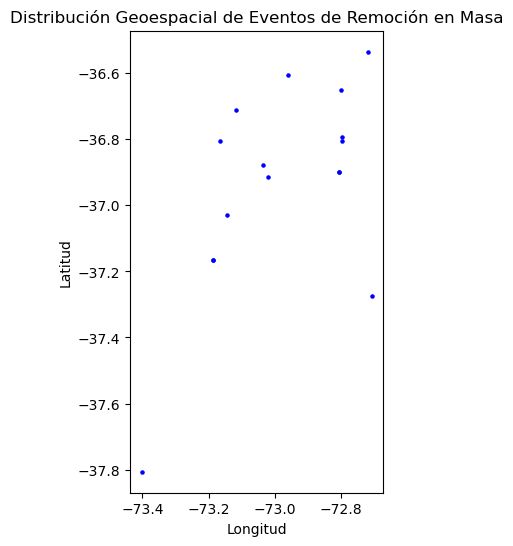

In [45]:
# Crear geometrías a partir de las coordenadas de latitud y longitud
geometry = [Point(xy) for xy in zip(biobio_df['Longitud'], biobio_df['Latitud'])]
geo_biobio = gpd.GeoDataFrame(biobio_df, geometry=geometry)

# Graficar el mapa con los eventos
geo_biobio.plot(figsize=(10, 6), markersize=5, color='blue')
plt.title("Distribución Geoespacial de Eventos de Remoción en Masa")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

In [46]:

# Crear el mapa centrado en Chile
mapa = folium.Map(location=[-35.6751, -71.5430], zoom_start=5)

# Crear un clúster de marcadores para los eventos
marker_cluster = MarkerCluster().add_to(mapa)

# Agregar puntos al clúster
for idx, row in biobio_df.iterrows():
    folium.Marker(
        location=[row['Latitud'], row['Longitud']],
        popup=f"Tipo: {row['Tipo de remoción en masa']}<br>Detonante: {row['Detonante']}<br>Año: {row['Año del evento']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# Mostrar el mapa
mapa

In [49]:
# Exportar el DataFrame filtrado a un archivo Excel
output_path = "biobio_remociones.xlsx"  # Nombre del archivo de salida
biobio_df.to_excel(output_path, index=False)

print(f"Archivo exportado exitosamente a: {output_path}")


Archivo exportado exitosamente a: biobio_remociones.xlsx


Se obtuvieron 1 imágenes.


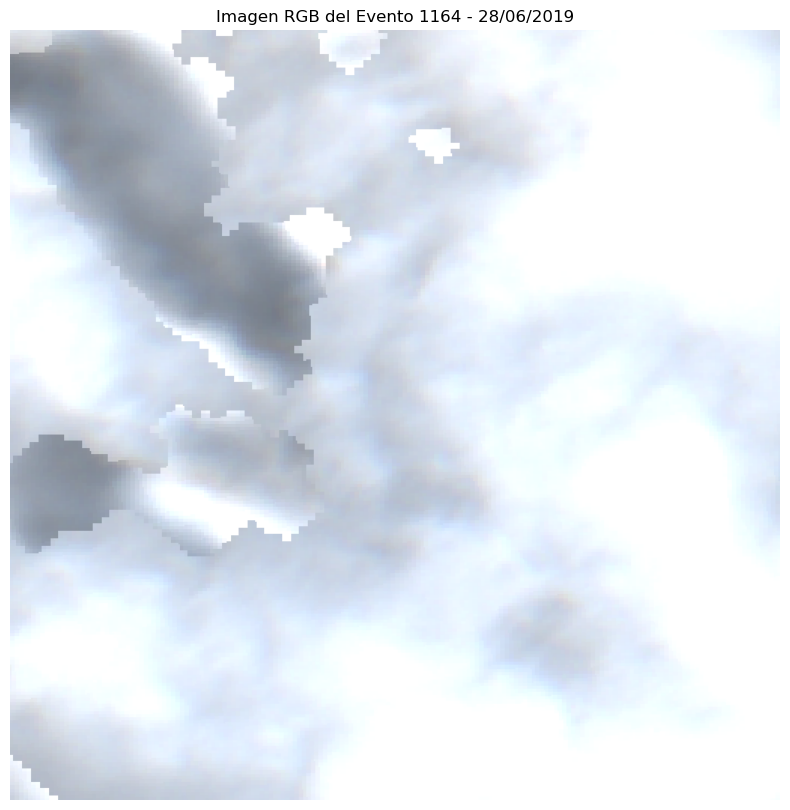

In [57]:
from sentinelhub import SentinelHubRequest, BBox, CRS, MimeType, DataCollection, SHConfig
import matplotlib.pyplot as plt
import numpy as np

# Configurar Sentinel-Hub API
config = SHConfig()
config.sh_client_id = 'b101d5fc-9363-46c7-b069-15ecfaed6b73'  # Reemplazar con tu client ID
config.sh_client_secret = 'CNXBeF1ZLLAsLoj4QlWta6giT2brnWRZ'  # Reemplazar con tu client secret

# Datos del evento
latitude, longitude = -36.534888, -72.716864  # Coordenadas del evento
time_interval = ('2019-06-01', '2019-06-30')  # Rango de fechas

# Definir bounding box del evento (1 km de buffer)
buffer = 0.01  # ~1 km en grados
coords = BBox(bbox=[longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer], crs=CRS.WGS84)

# Configurar solicitud de imágenes Sentinel-2
request = SentinelHubRequest(
    data_folder='sentinel_images',
    evalscript="""
        // Script para obtener una imagen RGB
        function setup() {
            return {
                input: ["B04", "B03", "B02"],  // Bandas: Rojo, Verde, Azul
                output: { bands: 3 }
            };
        }
        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=coords,
    size=(512, 512),  # Resolución
    config=config
)

# Ejecutar la solicitud
response = request.get_data()
print(f"Se obtuvieron {len(response)} imágenes.")

# Visualizar la imagen descargada (si existe)
if len(response) > 0:
    # Convertir la imagen a un array de numpy
    image = np.array(response[0])
    
    # Mostrar la imagen
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Imagen RGB del Evento 1164 - 28/06/2019")
    plt.show()
else:
    print("No se encontraron imágenes para este evento.")


Se observa que la imagen posee nubes sobre ella, por lo que se estima utilizar una mascara de nubes, en donde podemos filtrar las nubes automáticamente y enfocarnos en las áreas despejadas.

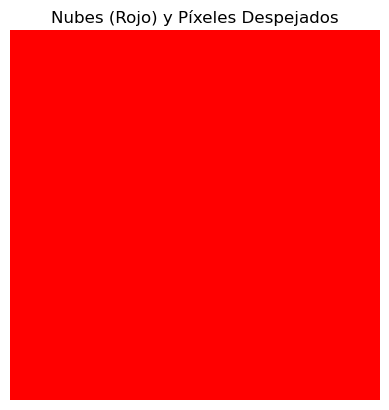

In [55]:
# Ajustar el script para visualizar los píxeles marcados como nubes
request = SentinelHubRequest(
    data_folder='sentinel_images',
    evalscript="""
        function setup() {
            return {
                input: ["B04", "B03", "B02", "CLM"],  // Bandas RGB y máscara de nubes
                output: { bands: 4 }
            };
        }
        function evaluatePixel(sample) {
            if (sample.CLM > 0) {  // Píxeles con nubes
                return [255, 0, 0, 1];  // Marcar nubes en rojo
            }
            return [sample.B04, sample.B03, sample.B02, 1];  // Píxeles sin nubes
        }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=coords,
    size=(512, 512),
    config=config
)

# Ejecutar la solicitud y mostrar la imagen
response = request.get_data()
if len(response) > 0:
    image = np.array(response[0])
    plt.imshow(image[:, :, :3])  # Mostrar la imagen con las nubes marcadas
    plt.axis('off')
    plt.title("Nubes (Rojo) y Píxeles Despejados")
    plt.show()
else:
    print("No se encontraron imágenes en este rango de fechas.")


### Probando con otro evento, ya que para las nubes nos funcionó el filtro.

Se obtuvieron 1 imágenes.


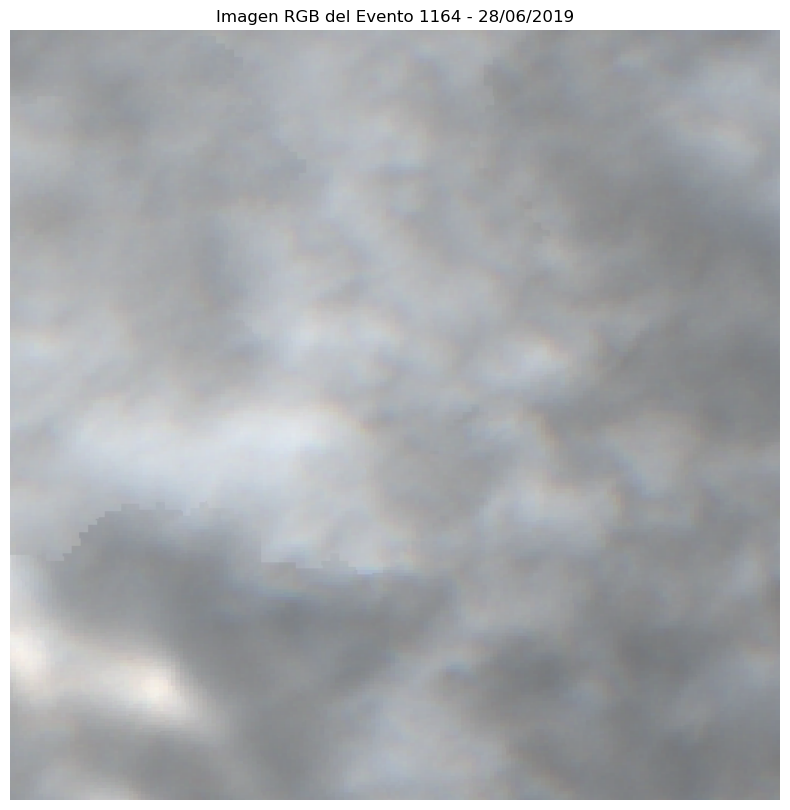

In [59]:
# Datos del evento con OBJECTID 1165
latitude, longitude = -36.650230, -72.050980  # Coordenadas del evento
time_interval = ('2019-06-01', '2019-06-30')  # Rango de fechas pre y post-evento

# Definir el bounding box para el evento
buffer = 0.01  # ~1 km en grados
coords = BBox(bbox=[longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer], crs=CRS.WGS84)

# Configurar la solicitud de imágenes Sentinel-2
request = SentinelHubRequest(
    data_folder='sentinel_images',
    evalscript="""
        function setup() {
            return {
                input: ["B04", "B03", "B02"],  // Bandas: Rojo, Verde, Azul
                output: { bands: 3 }
            };
        }
        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=coords,
    size=(512, 512),  # Resolución
    config=config
)

# Ejecutar la solicitud
response = request.get_data()
print(f"Se obtuvieron {len(response)} imágenes.")

# Visualizar la imagen descargada (si existe)
if len(response) > 0:
    # Convertir la imagen a un array de numpy
    image = np.array(response[0])
    
    # Mostrar la imagen
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Imagen RGB del Evento 1164 - 28/06/2019")
    plt.show()
else:
    print("No se encontraron imágenes para este evento.")


Se obtuvieron 1 imágenes.


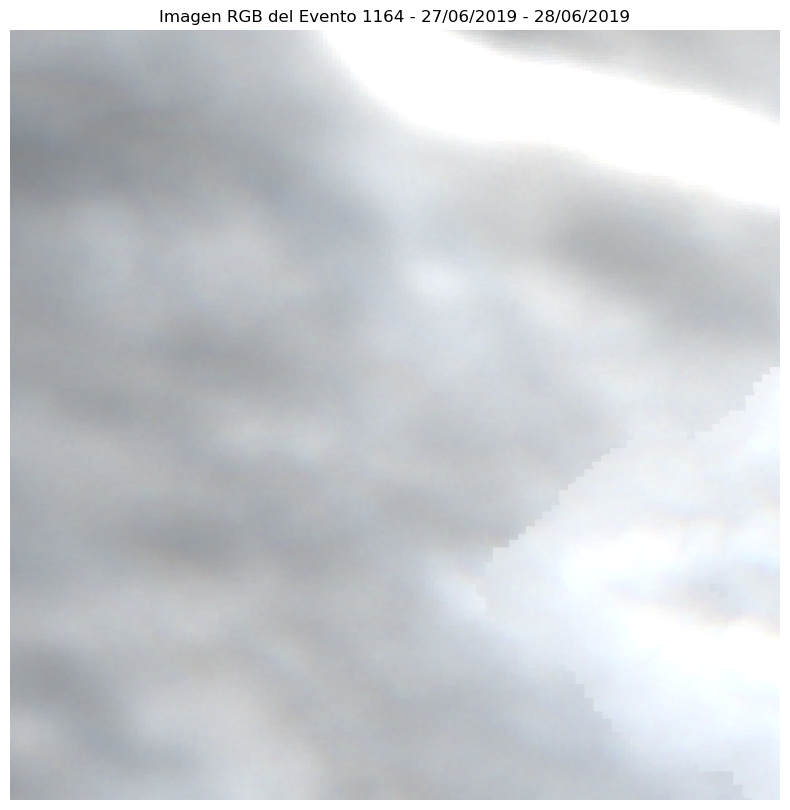

In [61]:
# Datos del evento con OBJECTID 1166
latitude, longitude = -36.712300, -72.088200  # Coordenadas del evento (ajustar según archivo)
time_interval = ('2019-06-01', '2019-06-30')  # Rango de fechas pre y post-evento

# Definir el bounding box para el evento
buffer = 0.01  # ~1 km en grados
coords = BBox(bbox=[longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer], crs=CRS.WGS84)

# Configurar la solicitud de imágenes Sentinel-2
request = SentinelHubRequest(
    data_folder='sentinel_images',
    evalscript="""
        function setup() {
            return {
                input: ["B04", "B03", "B02"],  // Bandas: Rojo, Verde, Azul
                output: { bands: 3 }
            };
        }
        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=coords,
    size=(512, 512),  # Resolución
    config=config
)

# Ejecutar la solicitud
response = request.get_data()
print(f"Se obtuvieron {len(response)} imágenes.")

# Visualizar la imagen descargada (si existe)
if len(response) > 0:
    # Convertir la imagen a un array de numpy
    image = np.array(response[0])
    
    # Mostrar la imagen
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Imagen RGB del Evento 1164 - 27/06/2019 - 28/06/2019")
    plt.show()
else:
    print("No se encontraron imágenes para este evento.")


In [63]:
%pip install earthengine-api
%pip install geemap


   ---------------------------------------- 0.0/457.3 kB ? eta -:--:--
   -- ------------------------------------- 30.7/457.3 kB ? eta -:--:--
   ---------- ----------------------------- 122.9/457.3 kB 1.8 MB/s eta 0:00:01
   --------------- ------------------------ 174.1/457.3 kB 1.5 MB/s eta 0:00:01
   ------------------ --------------------- 215.0/457.3 kB 1.5 MB/s eta 0:00:01
   ------------------------- -------------- 297.0/457.3 kB 1.5 MB/s eta 0:00:01
   --------------------------------- ------ 378.9/457.3 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------  450.6/457.3 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 457.3/457.3 kB 1.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.7 MB 3.8 MB/s eta 0:00:04
   ---------------------------------------- 0.2/12.7 MB 2.3 MB/s eta 0:00:06
    --------------------------------------- 0.3/12.7 MB 2.0 MB/s eta 0:0

In [3]:
ee.Initialize(project='ee-rodeaguilera')

In [4]:
# Coordenadas del evento y rango de fechas
latitude, longitude = -36.712300, -72.088200  # Coordenadas del evento 
start_date = '2019-06-01'
end_date = '2019-06-30'

# Crear un área de interés (buffer de 1 km)
aoi = ee.Geometry.Point([longitude, latitude]).buffer(1000).bounds()


In [5]:
# Colección Sentinel-2 (nivel L2A)
s2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(aoi) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))  # Menos del 50% de nubosidad

# Colección S2Cloudless
s2_cloudless = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY') \
    .filterBounds(aoi) \
    .filterDate(start_date, end_date)


c:\Users\rodag\anaconda3\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


In [6]:
# Función para aplicar la máscara de nubes
def mask_clouds(image):
    cloud_prob = s2_cloudless.filter(ee.Filter.eq('system:index', image.get('system:index'))).first()
    mask = cloud_prob.lt(40)  # Umbral de probabilidad de nubes (ajustable)
    return image.updateMask(mask)


In [7]:
# Aplica la máscara de nubes
s2_masked = s2.map(mask_clouds)

In [8]:
# Crea una imagen compuesta
composite = s2_masked.median().clip(aoi)

In [11]:
import geemap

# Visualizar el resultado
Map = geemap.Map()
Map.addLayer(composite, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 sin Nubes')
Map.centerObject(aoi, 12)
Map


Map(center=[-36.71229809426488, -72.08818247642472], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
nbr = composite.normalizedDifference(['B8', 'B12'])  # NIR y SWIR
Map.addLayer(nbr, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NBR')

In [60]:
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, DataCollection, MimeType
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Configurar Sentinel-Hub API
config = SHConfig()
config.sh_client_id = 'b101d5fc-9363-46c7-b069-15ecfaed6b73'  # Reemplazar con tu client ID
config.sh_client_secret = 'CNXBeF1ZLLAsLoj4QlWta6giT2brnWRZ'  # Reemplazar con tu client secret

# Datos del primer evento en la Región del Biobío
latitude, longitude = -36.534888, -72.716864  # Coordenadas del evento
start_date = "2019-06-01"  # Fecha pre-evento
end_date = "2019-07-31"  # Fecha post-evento

# Definir el área de interés (1 km de buffer)
buffer = 0.02  # ~1 km en grados
bbox = BBox([longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer], CRS.WGS84)

# Configurar la solicitud de imágenes Sentinel-2
request = SentinelHubRequest(
    evalscript="""
        // Script para obtener las bandas NIR (B08) y SWIR (B11)
        // Se calculan ambas bandas como salida
        return [B08, B11];
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=(start_date, end_date)
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=(512, 512),  # Resolución de salida
    config=config
)

# Obtener las imágenes
images = request.get_data()
print(f"Se obtuvieron {len(images)} imágenes.")

# Asegurarse de tener imágenes pre y post-evento
if len(images) < 2:
    print("No se encontraron imágenes pre o post-evento.")
else:
    # Separar imágenes pre y post-evento
    nir_pre = images[0][:, :, 0]  # Banda NIR pre-evento
    swir_pre = images[0][:, :, 1]  # Banda SWIR pre-evento

    nir_post = images[1][:, :, 0]  # Banda NIR post-evento
    swir_post = images[1][:, :, 1]  # Banda SWIR post-evento

    # Calcular NBR para pre y post-evento
    nbr_pre = (nir_pre - swir_pre) / (nir_pre + swir_pre)
    nbr_post = (nir_post - swir_post) / (nir_post + swir_post)

    # Calcular diferencia de NBR
    nbr_diff = nbr_pre - nbr_post

    # Visualizar la diferencia de NBR
    plt.imshow(nbr_diff, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Diferencia NBR (Pre vs Post)")
    plt.show()

    # Detectar áreas afectadas con un umbral
    threshold = -0.2
    affected_area_mask = nbr_diff < threshold

    # Calcular el área afectada en kilómetros cuadrados
    pixel_area_km2 = (10 * 10) / 1e6  # Cada píxel tiene un área de 100 m²
    affected_area_km2 = np.sum(affected_area_mask) * pixel_area_km2

    print(f"Área afectada estimada: {affected_area_km2:.2f} km²")


Se obtuvieron 1 imágenes.
No se encontraron imágenes pre o post-evento.


## 📊 **Resumen del Análisis Exploratorio Actual**

### **1. Carga de Datos**
- Se cargó correctamente el archivo **`catastro.xlsx`**.
- Contiene **2880 registros** y **19 columnas**.

---

### **2. Información del DataFrame**
- **Datos Completos**:
  - Todas las columnas tienen datos completos, excepto **`Autor de la fuente`** (3 valores nulos).
- **Tipos de Datos**:
  - Coordenadas (`Latitud` y `Longitud`): `float64`
  - Otras columnas: `object`

---

### **3. Estadísticas Descriptivas**
- **Rango de Años**:  
  - La mayoría de los eventos ocurrieron entre **1575 y 2021**.
- **Coordenadas**:  
  - Latitud y longitud dentro de rangos razonables.

---

### **4. Distribuciones**

- **Por Tipo de Remoción**:
  - **Flujo**: 1170 eventos  
  - **Deslizamiento**: 1047 eventos  
  - **Caída**: 498 eventos  

- **Por Detonante**:
  - **Lluvias**: 1196 eventos  
  - **Sin información**: 737 eventos  
  - **Evento Sísmico**: 376 eventos  

- **Por Año**:
  - Gran cantidad de eventos con año `0` (sin registro).

---

### **5. Visualización**
- Gráfico de barras que muestra la distribución de eventos por tipo de remoción en masa.

---

## ✅ **Siguientes Pasos**



### **1. Limpiar los Datos**
- **Valores Faltantes**:
  - Rellenar `Autor de la fuente` con **"Desconocido"**.  
- **Año `0`**:
  - Filtrar o investigar registros con año `0`.

In [13]:
catastro_df['Autor de la fuente'].fillna('Desconocido', inplace=True)

C:\Users\rodag\AppData\Local\Temp\ipykernel_12992\3197328450.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  catastro_df['Autor de la fuente'].fillna('Desconocido', inplace=True)


In [14]:
print(catastro_df.isnull().sum())

OBJECTID                                 0
Código de la remoción en masa            0
Región                                   0
Tipo de remoción en masa                 0
Tipo de material                         0
Clasificación de remoción en masa        0
Detonante                                0
Día del evento                           0
Mes de inicio del evento                 0
Año del evento                           0
Estación de ocurrencia del evento        0
Método de obtención de la información    0
Fuente de la información                 0
Autor de la fuente                       0
Nota                                     0
Enlace de documento asociado             0
Latitud                                  0
Longitud                                 0
Precisión de coordenadas                 0
dtype: int64


In [15]:
catastro_df = catastro_df[catastro_df['Año del evento'] != 0]

### **2. Análisis Geoespacial**
- Visualizar los eventos en un mapa utilizando **`geopandas`** y **`matplotlib`**.

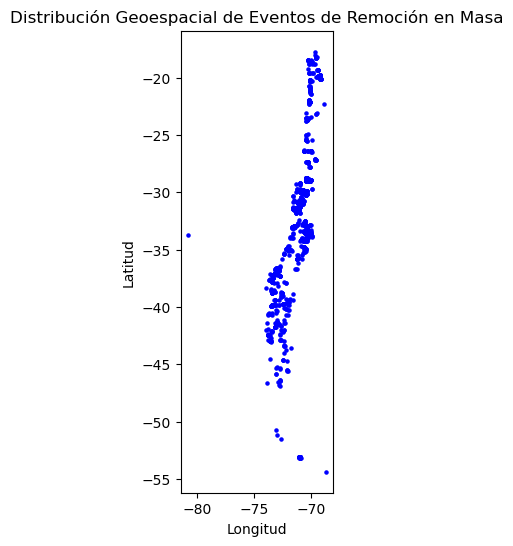

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Crear geometrías a partir de las coordenadas de latitud y longitud
geometry = [Point(xy) for xy in zip(catastro_df['Longitud'], catastro_df['Latitud'])]
geo_df = gpd.GeoDataFrame(catastro_df, geometry=geometry)

# Graficar el mapa con los eventos
geo_df.plot(figsize=(10, 6), markersize=5, color='blue')
plt.title("Distribución Geoespacial de Eventos de Remoción en Masa")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [17]:
%pip install folium

In [18]:
import folium
from folium.plugins import MarkerCluster

# Crear el mapa centrado en Chile
mapa = folium.Map(location=[-35.6751, -71.5430], zoom_start=5)

# Crear un clúster de marcadores para los eventos
marker_cluster = MarkerCluster().add_to(mapa)

# Agregar puntos al clúster
for idx, row in catastro_df.iterrows():
    folium.Marker(
        location=[row['Latitud'], row['Longitud']],
        popup=f"Tipo: {row['Tipo de remoción en masa']}<br>Detonante: {row['Detonante']}<br>Año: {row['Año del evento']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# Mostrar el mapa
mapa


In [19]:
# Crear el mapa
mapa = folium.Map(location=[-35.6751, -71.5430], zoom_start=5)

# Colores según tipo de remoción
colores = {
    'Deslizamiento': 'red',
    'Flujo': 'blue',
    'Caída': 'green',
    'Deformaciones de ladera': 'orange',
    'Propagación': 'purple'
}

# Agregar marcadores con colores específicos
for idx, row in catastro_df.iterrows():
    tipo = row['Tipo de remoción en masa']
    color = colores.get(tipo, 'gray')
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"Tipo: {tipo}<br>Detonante: {row['Detonante']}<br>Año: {row['Año del evento']}"
    ).add_to(mapa)

# Mostrar el mapa
mapa


In [20]:
from folium.plugins import HeatMap

# Crear el mapa
mapa_heatmap = folium.Map(location=[-35.6751, -71.5430], zoom_start=5)

# Crear una lista de coordenadas
coordenadas = list(zip(catastro_df['Latitud'], catastro_df['Longitud']))

# Agregar el HeatMap
HeatMap(coordenadas, radius=10, blur=15).add_to(mapa_heatmap)

# Mostrar el mapa
mapa_heatmap


In [21]:
mapa.save("mapa_interactivo.html")

In [22]:
# Contar eventos por región
eventos_por_region = catastro_df['Región'].value_counts()

# Graficar
plt.figure(figsize=(12, 6))
eventos_por_region.plot(kind='bar', color='teal')
plt.title("Distribución de Eventos por Región")
plt.xlabel("Región")
plt.ylabel("Número de Eventos")
plt.xticks(rotation=45)
plt.show()


### **3. Integrar con Sentinel-2**
- Descargar imágenes satelitales para eventos clave.  
- Detectar cambios en la superficie utilizando **NDVI** o técnicas de detección de cambios.

In [23]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'b101d5fc-9363-46c7-b069-15ecfaed6b73'
config.sh_client_secret = 'CNXBeF1ZLLAsLoj4QlWta6giT2brnWRZ'

# Verificar la configuración
print("Client ID:", config.sh_client_id)
print("Client Secret:", config.sh_client_secret)


Client ID: b101d5fc-9363-46c7-b069-15ecfaed6b73
Client Secret: CNXBeF1ZLLAsLoj4QlWta6giT2brnWRZ


In [24]:
%pip install requests

In [25]:
import requests

print(requests.__version__)

2.32.2


In [26]:
config.save()

In [27]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox

# Definir coordenadas del evento y período de interés
coords = BBox(bbox=[-71.17715259, -32.64314884, -71.17715259, -32.64314884], crs=CRS.WGS84)
time_interval = ('2020-03-01', '2020-03-31')

# Solicitud de imágenes de Sentinel-2
request = SentinelHubRequest(
    data_folder='sentinel_images',
    evalscript="""
        // Script para obtener una imagen RGB
        function setup() {
            return {
                input: ["B04", "B03", "B02"],
                output: { bands: 3 }
            };
        }
        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=coords,
    size=(512, 512)
)

# Ejecutar la solicitud
response = request.get_data()


In [28]:
print(type(response))
print(len(response))
print(response[0].shape if len(response) > 0 else "No hay datos en response")


<class 'list'>
1
(512, 512, 3)


In [29]:
buffer = 0.01  # Grados (~1 km)
coords = BBox(
    bbox=[-71.18 - buffer, -32.65 - buffer, -71.18 + buffer, -32.65 + buffer],
    crs=CRS.WGS84
)
print(f"Área definida: {coords}")


Área definida: -71.19000000000001,-32.66,-71.17,-32.64


C:\Users\rodag\AppData\Local\Temp\ipykernel_12992\1416089075.py:6: SHDeprecationWarning: The string representation of `BBox` will change to match its `repr` representation.
  print(f"Área definida: {coords}")


In [30]:
import sentinelhub
print(dir(sentinelhub))  # Confirma que 'BBox' y 'CRS' están disponibles


['AsyncProcessRequest', 'AwsDownloadFailedException', 'BBox', 'BBoxSplitter', 'Band', 'BatchCollection', 'BatchProcessClient', 'BatchProcessRequest', 'BatchRequest', 'BatchRequestStatus', 'BatchSplitter', 'BatchStatisticalRequest', 'BatchTileStatus', 'BatchUserAction', 'ByocCollection', 'ByocCollectionAdditionalData', 'ByocCollectionBand', 'ByocTile', 'CRS', 'CustomGridSplitter', 'CustomUrlParam', 'DataCollection', 'DownloadClient', 'DownloadFailedException', 'DownloadRequest', 'FisRequest', 'Geometry', 'GeopediaFeatureIterator', 'GeopediaImageRequest', 'GeopediaSession', 'GeopediaWmsRequest', 'HistogramType', 'MimeType', 'MosaickingOrder', 'OsmSplitter', 'ResamplingType', 'SHConfig', 'SHConstants', 'SentinelHubBYOC', 'SentinelHubBatch', 'SentinelHubBatchStatistical', 'SentinelHubCatalog', 'SentinelHubDownloadClient', 'SentinelHubRequest', 'SentinelHubSession', 'SentinelHubStatistical', 'SentinelHubStatisticalDownloadClient', 'ServiceType', 'ServiceUrl', 'TileSplitter', 'Unit', 'UtmGri

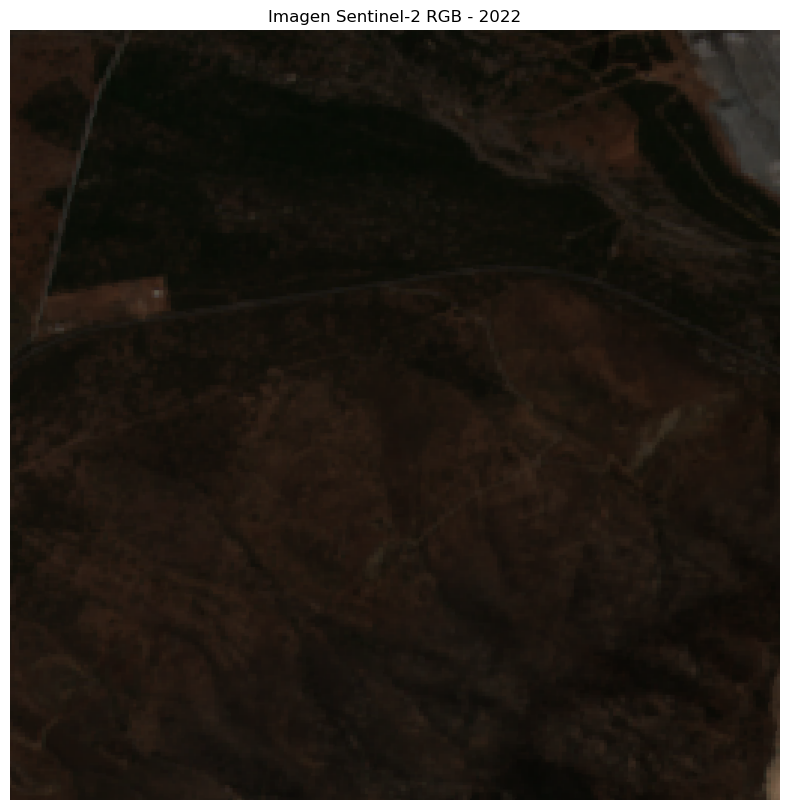

In [31]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType

# Cambia el rango de fechas a 2022
time_interval = ('2022-01-01', '2022-12-31')

# Crear la solicitud
request = SentinelHubRequest(
    data_folder='sentinel_images',
    evalscript="""
    function setup() {
        return {
            input: ["B04", "B03", "B02"],
            output: { bands: 3 }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=coords,
    size=(512, 512)
)

# Ejecutar la solicitud
response = request.get_data()

# Visualizar la imagen
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
plt.imshow(np.array(response[0]))
plt.title("Imagen Sentinel-2 RGB - 2022")
plt.axis('off')
plt.show()


In [32]:
image = np.array(response[0])  # Convierte la primera respuesta en un array numpy
print(f"Forma de la imagen: {image.shape}")  # Confirma la dimensión


Forma de la imagen: (512, 512, 3)


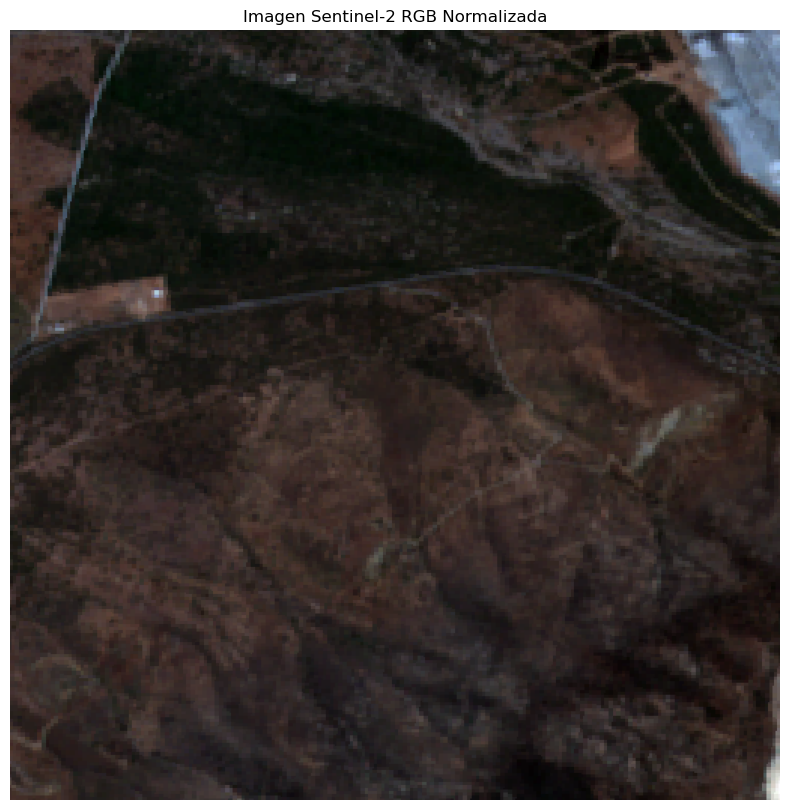

In [38]:
# Combinar las bandas normalizadas en una imagen RGB
rgb_image = np.stack((red, green, blue), axis=-1)

# Visualizar la imagen
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("Imagen Sentinel-2 RGB Normalizada")
plt.axis('off')
plt.show()


In [39]:
# Ajustar el tamaño de la imagen para mejorar la resolución
size = (1024, 1024)  # Incrementar resolución (más píxeles)

request = SentinelHubRequest(
    data_folder='sentinel_images',
    evalscript="""
    function setup() {
        return {
            input: ["B04", "B03", "B02"],
            output: { bands: 3 }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2022-01-01', '2022-12-31')
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=coords,
    size=size  # Mayor tamaño mejora la resolución
)


In [43]:
from sentinelhub import SentinelHubCatalog, DataCollection, bbox_to_dimensions
from datetime import datetime

# Inicializar el catálogo
catalog = SentinelHubCatalog()

# Definir las fechas
time_before = ('2021-01-01', '2021-12-31')  # Antes del evento
time_after = ('2022-01-01', '2022-12-31')   # Después del evento

# Buscar imágenes antes del evento
search_before = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=coords,
    time=time_before
)
results_before = list(search_before)
print(f"Imágenes encontradas antes del evento: {len(results_before)}")

# Buscar imágenes después del evento
search_after = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=coords,
    time=time_after
)
results_after = list(search_after)
print(f"Imágenes encontradas después del evento: {len(results_after)}")


Imágenes encontradas antes del evento: 72
Imágenes encontradas después del evento: 74


In [47]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, BBox, CRS

# Paso 1: Definir el área de interés
buffer = 0.01  # Grados (~1 km)
coords = BBox(
    bbox=[-71.18 - buffer, -32.65 - buffer, -71.18 + buffer, -32.65 + buffer],
    crs=CRS.WGS84
)

# Paso 2: Definir el evalscript como variable
evalscript = """
function setup() {
    return {
        input: ["B04", "B03", "B02"],
        output: { bands: 3 }
    };
}
function evaluatePixel(sample) {
    return [sample.B04, sample.B03, sample.B02];
}
"""

# Paso 3: Crear solicitudes para antes y después del evento
size = (1024, 1024)  # Resolución de la imagen

# Fechas ajustadas
time_before = ('2021-01-15', '2021-01-20')  # Antes del evento
time_after = ('2022-02-15', '2022-02-20')   # Después del evento

# Solicitud antes del evento
request_before = SentinelHubRequest(
    data_folder='sentinel_images',
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_before
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=coords,
    size=size
)

# Solicitud después del evento
request_after = SentinelHubRequest(
    data_folder='sentinel_images',
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_after
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=coords,
    size=size
)

# Paso 4: Descargar las imágenes
response_before = request_before.get_data()
response_after = request_after.get_data()

# Paso 5: Normalizar y visualizar
import matplotlib.pyplot as plt
import numpy as np

def normalize_band(band):
    return ((band - band.min()) / (band.max() - band.min() + 1e-6) * 255).astype('uint8')

def visualize_images(image_before, image_after):
    # Normalizar las bandas
    rgb_before = np.stack([normalize_band(image_before[:, :, i]) for i in range(3)], axis=-1)
    rgb_after = np.stack([normalize_band(image_after[:, :, i]) for i in range(3)], axis=-1)
    
    # Mostrar las imágenes
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    axes[0].imshow(rgb_before)
    axes[0].set_title("Antes del Evento")
    axes[0].axis('off')

    axes[1].imshow(rgb_after)
    axes[1].set_title("Después del Evento")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Convertir las respuestas en arrays y visualizar
image_before = np.array(response_before[0])
image_after = np.array(response_after[0])

visualize_images(image_before, image_after)


### Calculo la diferencia entre las imagenes

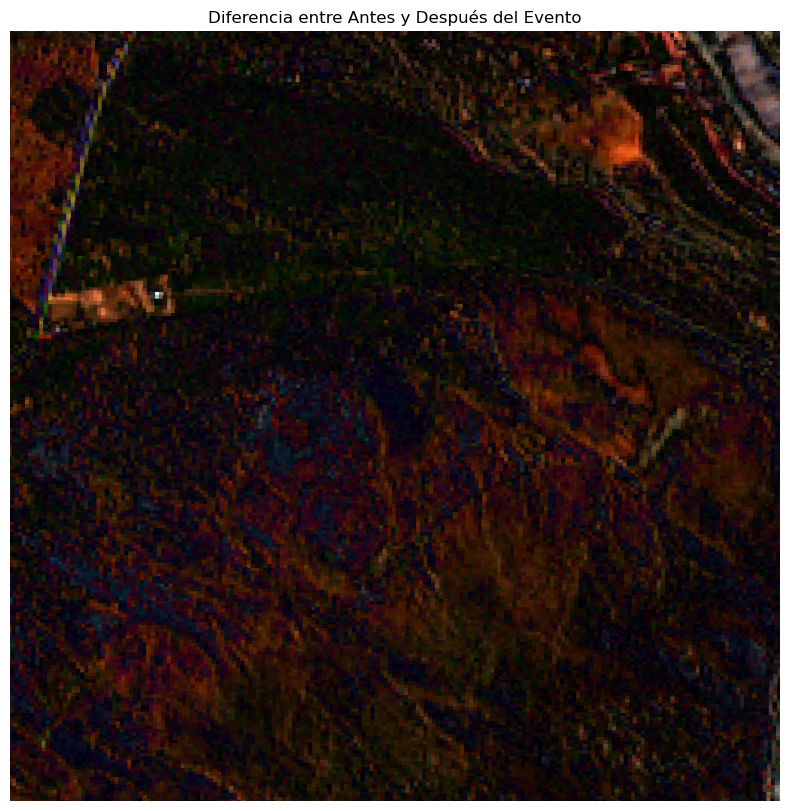

In [48]:
# Calcular la diferencia entre las imágenes
diff_image = np.abs(image_after.astype('float32') - image_before.astype('float32'))

# Normalizar la diferencia para visualización
def normalize_band(band):
    return ((band - band.min()) / (band.max() - band.min() + 1e-6) * 255).astype('uint8')

diff_image_normalized = np.stack([normalize_band(diff_image[:, :, i]) for i in range(3)], axis=-1)

# Mostrar la diferencia
plt.figure(figsize=(10, 10))
plt.imshow(diff_image_normalized)
plt.title("Diferencia entre Antes y Después del Evento")
plt.axis('off')
plt.show()
